In questo notebook proveremo a creare una semplice Rete Neurale Convolutiva con l'ausilio di Keras. Keras è un modulo di tensorflow che fornisce un'API di alto livello per costruire e addestrare reti neurali.

Per prima cosa importiamo il dataset MNIST, integrato in Keras




In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import numpy as np
from PIL import Image

Andiamo a importarci il dataset mnist tramite tensorflow.keras.datasets

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


In [ ]:
print(X_train[0])

print(X_train[0].shape)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

Utilizziamo plt.imshow per convertire la matrice 28x28 X_train[0] in una immagine


5


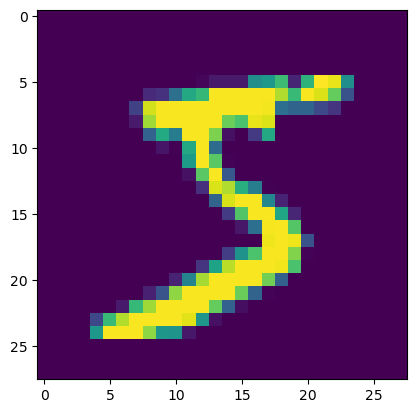

In [ ]:
plt.imshow(X_train[0])


#Stampiamo l'etichetta in y_train
print(y_train[0])

Facciamo una considerazione sulla shape del dataset e delle singole immagini. Partiamo da una shape di `(60000, 28, 28)` il che significa che **abbiamo 60000 immagini di dimensioni 28x28**. 

Questo significa che abbiamo una sequenza di immagini bidimensionali in cui *non* è specificato il numero di canali. Abbiamo bisogno, per far funzionare la nostra rete in Keras, di dire esplicitamente che stiamo usando delle immagini con 3 dimensioni (la terza dimensione esprime il numero di canali ed è quella che effettivamente rende il nostro input un volume). 

Per questo motivo facciamo un reshape dei dataset in ingresso (sia quello di train che quello di test)

In pratica passiamo da 28x28 a 28x28x1 in modo da dire alla rete che ogni immagine ha 1 canale (in questo caso specifico)


In [ ]:
print(X_train.shape)

X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

print(X_train.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


Andiano ora a normalizzare i valori nelle immagini (sia in train che in test) da 0 a 1

In [ ]:
X_train = X_train/255
X_test = X_test/255

Trasformiamo le etichette, dal numero che rappresentanto ad un one-hot-encodin (lo facciamo sia per il train che per il test)

In [ ]:
from tensorflow.keras.utils import to_categorical

print(y_train[0])

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(y_train[0])

5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Procediamo con la definizione del modello (vedi analisi dimensionale nei commenti)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten

#create model
model = Sequential()

# Prima convoluzione.
# Ricordiamo che nel primo livello, usando sequential() dobbiamo specificare la dimensione dell'imput,
# in modo che la rete sa come gestirlo.
# --
# 64 rappresenta il numero di filtri, mentre kernel_size=3 indica la dimensione dei filtri (quadrati)
# otterrò quindi 64 filtri 3x3 con relu come funzione di attivazione sulla convoluzione
# --
# In pratica qui ho 3x3x64 filtri da ottimizzare = 576 a cui devo aggiungere un bias per ognuno dei filtri
# che saranno poi passati alla funzione di attivazione (relu in questo caso) assieme ai filtri.
#
# Abbiamo quini 3x3x64 + 64 = 640 filtri
model.add(
    Conv2D(
        64, 
        kernel_size=3, 
        activation='relu', 
        input_shape=(28,28,1) # This is the shape of each input image, 28,28,1 with the 1 signifying that the images are greyscale.
    )
)

# Seconda convoluzione
# Ricordiamo qui che la dimensione della feautere map è data da:
# [(W−K+2P)/S]+1
# Dove
# W is the input volume (28)
# K is the Kernel size - (3)
# P is the padding - (0: default)
# S is the stride - (1: default)
# Da cui abbiamo
# [ (28−3 + 2*0)/1] + 1 = 26
# ---
# Quindi questo punto ho una feature maps 26x26x64 che sarà l'input della mia prossima convoluzione 

# In queststa convoluzione abbiamo un input di 26x26x64, quindi i nostri filtri saranno kernel_size*kernel_size*64
# Dunque in questo caso avremmo 32 filtri di 3x3x64 a cui si sommano i 32 bias.
# Questo ci da un totale di 3x3x64x32 + 32 = 18,464 parametri
model.add(
    Conv2D(
        32, 
        kernel_size=3, 
        activation='relu'
    )
)


# Poiché [ (26−3 + 2*0)/1] + 1 = 24, allora qui otteniamo una feature map di 24x24x32 che andrà poi in input al prossimo livello flatten -> dense


# A questo punto appiattiamo la feature map precedente dato che questo step rappresenterà l'input
# della rete dense che si aspetta un vettore di "n" features
# --
# Questo appiattimento ci darà un vettore di dimensione 24x24x32 = 18,432 elementi, ma zero parametri, dato che la flatten non ha parametri
model.add(
    Flatten() # Flatten serves as a connection between the convolution and dense layers.
)

# In questo step abbiamo una rete dense di unit=10 neuroni, connessi a 18,432 feauters in input.
# Questo genera 184,320 parametri a cui si sommano di 10 bias dei singoli neuroni, per totale di 184,330 paramentri totali
model.add(
    Dense(
        units=10, 
        activation='softmax' # Softmax makes the output sum up to 1 so the output can be interpreted as probabilities.
    )
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 10)                184330    
                                                                 
Total params: 203,434
Trainable params: 203,434
Non-trainable params: 0
_________________________________________________________________


2023-05-18 13:11:19.037519: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 13:11:19.038799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-18 13:11:19.039458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-18 13:11:19.040018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=4)

Epoch 1/4


2023-05-18 13:11:29.864589: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-05-18 13:11:31.837446: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-18 13:11:31.838012: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-18 13:11:31.838051: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-05-18 13:11:31.838645: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-18 13:11:31.838741: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1875/1875 [==============================] - 11s 3ms/step - loss: 0.1268 - accuracy: 0.9625 - val_loss: 0.0614 - val_accuracy: 0.9812
Epoch 2/4
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0471 - accuracy: 0.9855 - val_loss: 0.0533 - val_accuracy: 0.9833
Epoch 3/4
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0306 - accuracy: 0.9901 - val_loss: 0.0571 - val_accuracy: 0.9846
Epoch 4/4
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0211 - accuracy: 0.9933 - val_loss: 0.0523 - val_accuracy: 0.9851


In [ ]:
test_score = model.evaluate(X_test, y_test)
print(test_score)
print(model.metrics_names)
print('Test metrics: {} {:.4f}, {} {:.2f}%'.format(
    model.metrics_names[0], 
    test_score[0], 
    model.metrics_names[1],
    test_score[1] * 100
    )
)

313/313 [==============================] - 1s 2ms/step - loss: 0.0523 - accuracy: 0.9851
[0.05231702700257301, 0.9850999712944031]
['loss', 'accuracy']
Test metrics: loss 0.0523, accuracy 98.51%


loss
accuracy
val_loss
val_accuracy


Text(0, 0.5, 'loss')

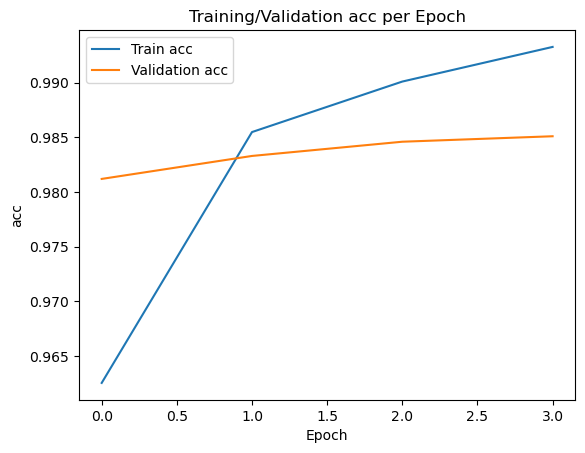

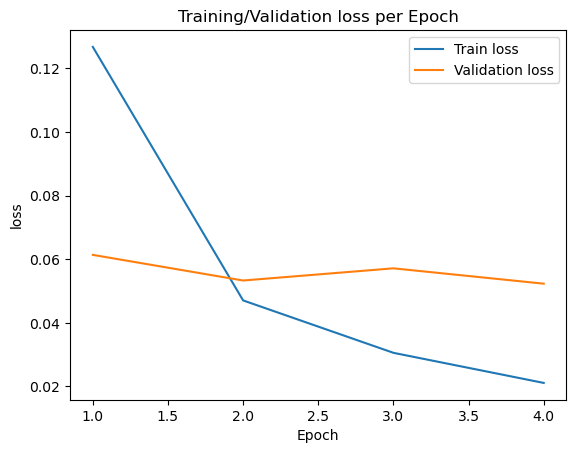

In [ ]:
for i in history.history:
  print(i)


f, ax = plt.subplots()
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])

# disegno della legenda nella migliore posizione automaticamente: loc = 0.
ax.legend(['Train acc', 'Validation acc'], loc = 0)
ax.set_title('Training/Validation acc per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('acc')

f2, ax2 = plt.subplots()
ax2.plot([None] + history.history['loss'])
ax2.plot([None] + history.history['val_loss'])
ax2.legend(['Train loss', 'Validation loss'], loc = 0)
ax2.set_title('Training/Validation loss per Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('loss')


In [ ]:
prediction = model.predict(X_test[0:10])
print(prediction.shape)

classes = np.argmax(prediction, axis=1)
print(classes)

length = 100
success = 0

for i in range(0, len(classes)):
    print("Prediction -> ", classes[i])
    print("Label      -> ", np.argmax(y_test[i]))
    print("\n")

    if classes[i] == np.argmax(y_test[i]):
        success = success + 1
    
    
print("Predizioni totali: {} su {} ({}%)".format(success, length, success/length*100))


1/1 [==============================] - 0s 16ms/step
(10, 10)
[7 2 1 0 4 1 4 9 6 9]
Prediction ->  7
Label      ->  7


Prediction ->  2
Label      ->  2


Prediction ->  1
Label      ->  1


Prediction ->  0
Label      ->  0


Prediction ->  4
Label      ->  4


Prediction ->  1
Label      ->  1


Prediction ->  4
Label      ->  4


Prediction ->  9
Label      ->  9


Prediction ->  6
Label      ->  5


Prediction ->  9
Label      ->  9


Predizioni totali: 9 su 100 (9.0%)


Carichi

In [ ]:
img = Image.open('.png')
img

NameError: ignored

In [ ]:
# Convert the image to a numpy array
img_array = np.array(img)

# Display the image using plt.imshow()
plt.imshow(img_array)
plt.show()

NameError: ignored

In [ ]:
print(img_array.shape)
img_array = img_array.reshape(1, 28,28,1)
print(img_array.shape)

(28, 28)
(1, 28, 28, 1)


In [ ]:
p = model.predict(img_array)
print(f"il numero predetto è un {np.argmax(p, axis=1)[0]}")
p

1/1 [==============================] - 0s 19ms/step
il numero predetto è un 5


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)